In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2
import youtube_dl
from celluloid import Camera
from PIL import Image
from IPython.display import HTML, display
from matplotlib.animation import FuncAnimation, PillowWriter
%matplotlib inline

from ipynb.fs.full.COCO_Keypoints import PoseTrack_Keypoint_Pairs, PoseTrack_COCO_Keypoint_Ordering

In [2]:
DATA_PATH = '../dataset/'
FILE = DATA_PATH + 'wimbledon_2019_womens_final_halep_williams__fduc5bZx3ss.pose.json'
VIDEO_URL = 'https://www.youtube.com/watch?v=' + FILE.split('__')[1].split('.')[0]
W = 1920
H = 1080
f = json.load(open(FILE, 'r'))

# 58 min video --> 3366 seconds, frame rate: 25 fps, total frames = 33660. W=1920 H=1080

# File structure
# 3 lists: person, racket, ball  (each one has a different length)
# Person
# 2 element list: timestamp, person detections
# Person detection: score, xywh, pose (17 keypoints)

In [3]:
def plot_frame_from_youtube_video(frame_no):
    ydl_opts = {'quiet': True}
    ydl = youtube_dl.YoutubeDL(ydl_opts)
    info_dict = ydl.extract_info(VIDEO_URL, download=False)
    formats = info_dict.get('formats',None)
    for f in formats:
        if f['format_id'] == '399':
            url = f.get('url',None)
            cap = cv2.VideoCapture(url)
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)
            ret, frame = cap.read()
            if ret:
                plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                return frame
                #plt.show()
            else:
                print('No frame obtained. Rerun code.')
    return None

In [4]:
def plot_frame_from_local_video(frame_no):
    cap = cv2.VideoCapture(FILE.split('pose')[0] + 'mp4')
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)
    ret, frame = cap.read()
    if ret:
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        return frame
        #plt.show()
    else:
        print('No frame obtained. Rerun code.')
        return None

In [5]:
def plot_pose(data):
    keypoints = data['pose'][0]
    x,y,w,h = data['xywh']
    
    fig, ax = plt.subplots()
    for i, p in enumerate(keypoints):
        # Avoid plotting ears and nose
        k = PoseTrack_COCO_Keypoint_Ordering[i]
        if 'ear' in k or 'nose' in k: continue
        ax.scatter(p[0]-x,p[1]-y,c='b',marker='.')
        ax.annotate(k, (p[0]-x, p[1]-y))
            
    for joint_pair in PoseTrack_Keypoint_Pairs:
        
        ind_1 = PoseTrack_COCO_Keypoint_Ordering.index(joint_pair[0])
        ind_2 = PoseTrack_COCO_Keypoint_Ordering.index(joint_pair[1])
        
        color = joint_pair[2]
        x1, y1, _ = keypoints[ind_1]
        x2, y2, _ = keypoints[ind_2]
                
        plt.plot([x1-x, x2-x], [y1-y, y2-y], c=color, linewidth=2)
        
    plt.xlim(0,w)
    plt.ylim(h,0)
    plt.gca().set_aspect('equal')
    plt.show()

In [8]:
def plot_poses_in_frame(poses_p1, poses_p2, frame_no):
    
    plt.figure(figsize=(8,8))
    
    # Plot main image
    ax1 = plt.subplot(2, 1, 2)
    ax1.set_anchor('W')
    
    #frame = plot_frame_from_youtube_video(frame_no)
    frame = plot_frame_from_local_video(frame_no)
    if frame is None:
        plt.close()
        return
        
    # Plot player 1
    
    ax2 = plt.subplot(2, 2, 1)
    ax2.set_anchor('W')
    keypoints = poses_p1['pose'][0]
    x,y,w,h = list(map(int, poses_p1['xywh']))
    plt.imshow(cv2.cvtColor(frame[y:y+h,x:x+w,:], cv2.COLOR_BGR2RGB),alpha=0.6)
    for joint_pair in PoseTrack_Keypoint_Pairs:
        
        ind_1 = PoseTrack_COCO_Keypoint_Ordering.index(joint_pair[0])
        ind_2 = PoseTrack_COCO_Keypoint_Ordering.index(joint_pair[1])
        
        color = joint_pair[2]
        x1, y1, _ = keypoints[ind_1]
        x2, y2, _ = keypoints[ind_2]
                
        plt.plot([x1-x, x2-x], [y1-y, y2-y], c=color, linewidth=2)
    
    
    # Plot player 2
    
    ax3 = plt.subplot(2, 2, 2)
    ax3.set_anchor('W')
    keypoints = poses_p2['pose'][0]
    x,y,w,h = list(map(int, poses_p2['xywh']))
    plt.imshow(cv2.cvtColor(frame[y:y+h,x:x+w,:], cv2.COLOR_BGR2RGB),alpha=0.6)
    for joint_pair in PoseTrack_Keypoint_Pairs:
        
        ind_1 = PoseTrack_COCO_Keypoint_Ordering.index(joint_pair[0])
        ind_2 = PoseTrack_COCO_Keypoint_Ordering.index(joint_pair[1])
        
        color = joint_pair[2]
        x1, y1, _ = keypoints[ind_1]
        x2, y2, _ = keypoints[ind_2]
                
        plt.plot([x1-x, x2-x], [y1-y, y2-y], c=color, linewidth=2)
    
    plt.tight_layout()
    plt.show()

In [23]:
def plot_video(initial_frame, final_frame, data):
    
    FRAME_HEIGHT = 300
    FPS = 25
    fig = plt.figure()
    camera = Camera(fig)
    
    for f in range(initial_frame, final_frame+1):
        keypoints =  data[f][1][0]['pose'][0]
        
        x,y,w,h = list(map(int, data[f][1][0]['xywh']))
        scale = FRAME_HEIGHT/h
        x_offset = int((FRAME_HEIGHT/2 - w))
        
        cap = cv2.VideoCapture(FILE.split('pose')[0] + 'mp4')
        cap.set(cv2.CAP_PROP_POS_FRAMES, data[f][0])
        ret, frame = cap.read()
        
        if not ret:
            break
            
        frame = Image.fromarray(cv2.cvtColor(frame[y:y+h,x:x+w,:], cv2.COLOR_BGR2RGB))
        w,h = frame.size
        ar = w/h
        frame = frame.resize((int(FRAME_HEIGHT*ar),FRAME_HEIGHT), Image.ANTIALIAS)
        new_im = Image.new('RGBA', (FRAME_HEIGHT, FRAME_HEIGHT), (0, 0, 0, 0))
        new_im.paste(frame, (x_offset, 0))
        
        plt.imshow(new_im)
        
        for joint_pair in PoseTrack_Keypoint_Pairs:
        
            ind_1 = PoseTrack_COCO_Keypoint_Ordering.index(joint_pair[0])
            ind_2 = PoseTrack_COCO_Keypoint_Ordering.index(joint_pair[1])

            color = joint_pair[2]
            x1, y1, _ = keypoints[ind_1]
            x2, y2, _ = keypoints[ind_2]

            plt.plot([(x1-x)*scale+x_offset, (x2-x)*scale+x_offset], 
                     [(y1-y)*scale, (y2-y)*scale], 
                     c=color, linewidth=2)
        camera.snap()
        
    plt.close()
    animation = camera.animate()
    display(HTML(animation.to_jshtml()))
    #animation.save('animation.gif', writer=PillowWriter(fps=FPS))


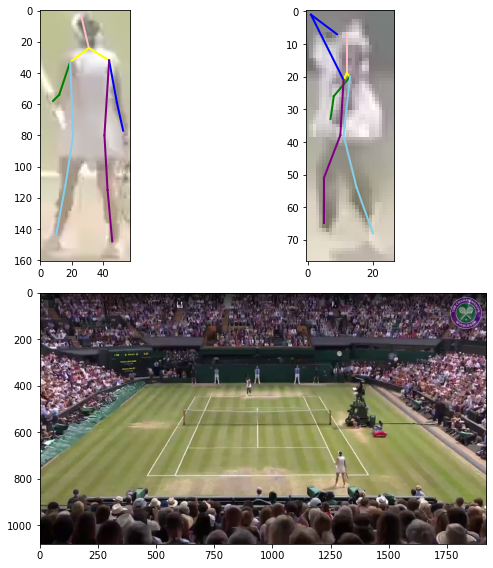

In [9]:
POSE_NUM = 0
plot_poses_in_frame(f['person'][POSE_NUM][1][0], f['person'][POSE_NUM][1][1],frame_no=f['person'][POSE_NUM][0])

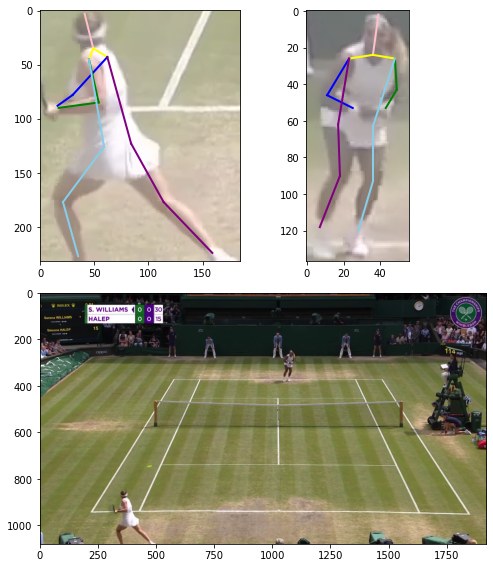

In [25]:
POSE_NUM = 1000
plot_poses_in_frame(f['person'][POSE_NUM][1][0], f['person'][POSE_NUM][1][1],frame_no=f['person'][POSE_NUM][0])

In [24]:
plot_video(0,5,f['person'])